EMD分解过程示意图

In [1]:
from scipy.signal import argrelextrema
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
import pandas as pd
import numpy as np
import os
import mne
from mne import io

读取脑电信号

In [3]:
# 路径
data_path = 'D:\\project\\BrainEEG\\data_fif\\epoch_fif_data\\'
raw_fname = data_path + 'pid01-epo.fif'
# 读取mne数据
epochs_data = mne.read_epochs('D:\\project\\BrainEEG\\data_fif\\epoch_fif_data\\pid01-epo.fif')
events_id_dict = epochs_data.event_id  # events name
channels = epochs_data.ch_names   # channels name
df = pd.DataFrame(columns=channels, index=[])

Reading D:\project\BrainEEG\data_fif\epoch_fif_data\pid01-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3999.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated


In [4]:
# 通道名
print(channels)

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 'FT10', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'Fpz', 'F9', 'AFF5h', 'AFF1h', 'AFF2h', 'AFF6h', 'F10', 'FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'FTT10h', 'TPP9h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'CPP2h', 'CPP4h', 'CPP6h', 'TPP8h', 'TPP10h', 'POO9h', 'POO1', 'POO2', 'POO10h', 'Iz', 'AFp1', 'AFp2', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h', 'P9', 'PPO9h', 'PPO5h', 'PPO1h', 'PPO2h', 'PPO6h', 'PPO10h', 'P10', 'I1', 'OI1h', 'OI2h', 'I2']


In [16]:
# 读取其中一条信号
i = 1
channel_name = 'Fp1'
data = epochs_data[i].pick_channels([channel_name]).get_data() * 1e6
data = data.reshape(4000)
data

array([ 1.92103312, -0.26258547, -2.36453525, ...,  5.92065044,
        5.23535346,  3.84904843])

求极大值点和极小值点

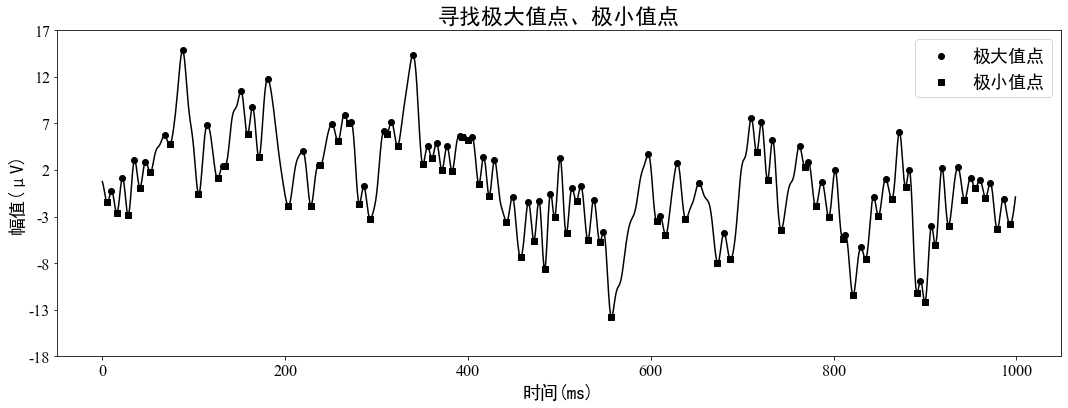

In [17]:
# 为了看清楚，只选取1000ms-2000ms
data = data[1000:2000]
# 获取极大值
max_peaks = argrelextrema(data, np.greater)
#获取极小值
min_peaks = argrelextrema(data, np.less)

# 解决中文乱码问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制极值点图像
plt.figure(figsize = (18,6))
plt.plot(data, c='black')
plt.scatter(max_peaks, data[max_peaks], c='black', marker='o', label='极大值点')
plt.scatter(min_peaks, data[min_peaks], c='black', marker='s', label='极小值点')
plt.legend()
plt.xlabel('时间(ms)', fontsize=18)
plt.ylabel('幅值(μV)', fontsize=18)
plt.xticks(np.arange(0, 1050, 200),fontproperties = 'Times New Roman', size = 16)
plt.yticks(np.arange(-18, 18, 5),fontproperties = 'Times New Roman', size = 16)
plt.title("寻找极大值点、极小值点", fontsize=22)
plt.legend(fontsize=18)
plt.savefig("EMD_ProcessDrawing1_new.png", dpi=300, bbox_inches = 'tight')

拟合包络函数

这一步是EMD的核心步骤，也是分解出本征模函数IMFs的前提

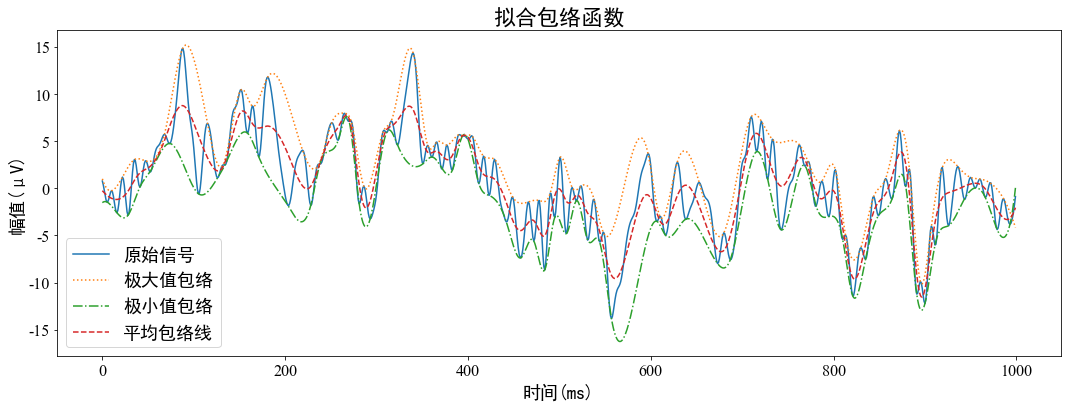

In [25]:
#进行样条差值
import scipy.interpolate as spi

index = list(range(len(data)))

# 获取极值点
max_peaks = list(argrelextrema(data, np.greater)[0])
min_peaks = list(argrelextrema(data, np.less)[0])

# 将极值点拟合为曲线
ipo3_max = spi.splrep(max_peaks, data[max_peaks],k=3) #样本点导入，生成参数
iy3_max = spi.splev(index, ipo3_max) #根据观测点和样条参数，生成插值

ipo3_min = spi.splrep(min_peaks, data[min_peaks],k=3) #样本点导入，生成参数
iy3_min = spi.splev(index, ipo3_min) #根据观测点和样条参数，生成插值

# 计算平均包络线
iy3_mean = (iy3_max+iy3_min)/2

# 绘制图像
plt.figure(figsize = (18,6))
plt.plot(data, label='原始信号', linestyle="-")
plt.plot(iy3_max, label='极大值包络', linestyle=':')
plt.plot(iy3_min, label='极小值包络', linestyle='-.')
plt.plot(iy3_mean, label='平均包络线', linestyle='--')
plt.legend()
plt.xlabel('时间(ms)', fontsize=18)
plt.ylabel('幅值(μV)', fontsize=18)
plt.xticks(fontproperties = 'Times New Roman', size = 16)
plt.yticks(fontproperties = 'Times New Roman', size = 16)
plt.title("拟合包络函数", fontsize=22)
plt.legend(fontsize=18)
plt.savefig("EMD_ProcessDrawing2_new.png", dpi=600, bbox_inches = 'tight')

获取本征模函数（IMF）

No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude')

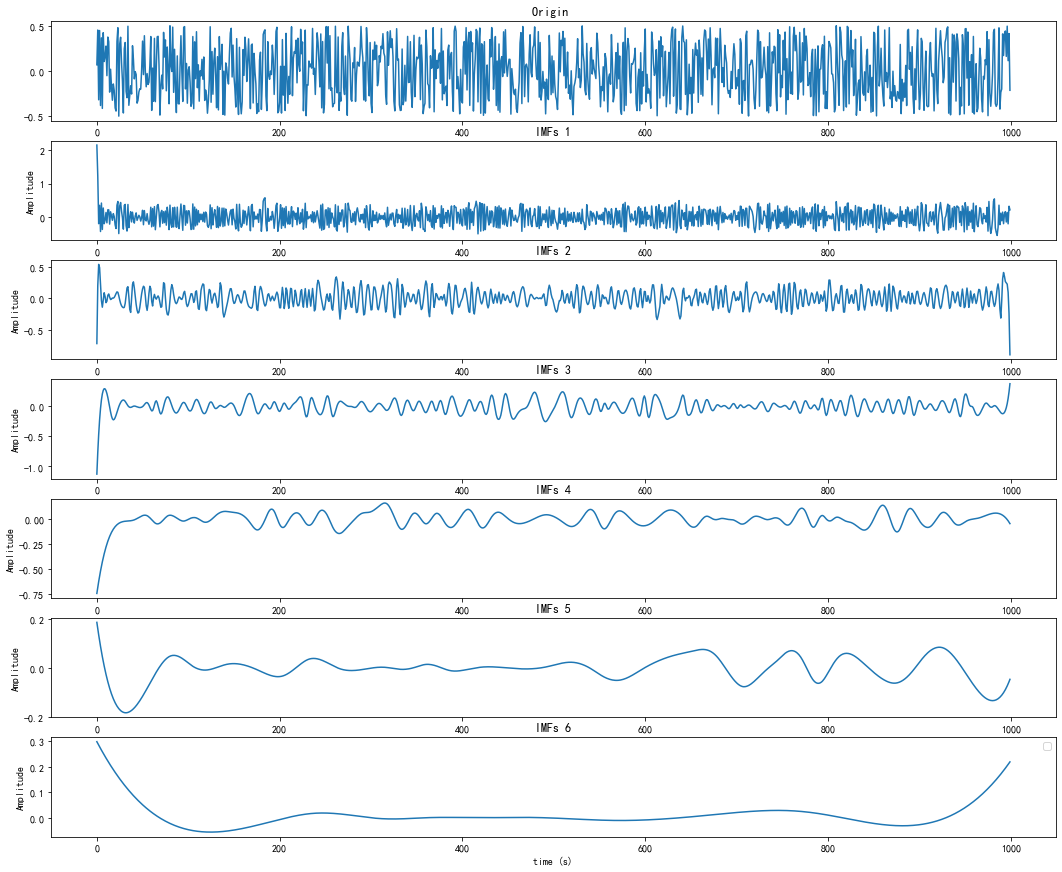

In [87]:
def sifting(data):
    index = list(range(len(data)))

    max_peaks = list(argrelextrema(data, np.greater)[0])
    min_peaks = list(argrelextrema(data, np.less)[0])

    ipo3_max = spi.splrep(max_peaks, data[max_peaks],k=3) #样本点导入，生成参数
    iy3_max = spi.splev(index, ipo3_max) #根据观测点和样条参数，生成插值

    ipo3_min = spi.splrep(min_peaks, data[min_peaks],k=3) #样本点导入，生成参数
    iy3_min = spi.splev(index, ipo3_min) #根据观测点和样条参数，生成插值

    iy3_mean = (iy3_max+iy3_min)/2
    return data-iy3_mean


def hasPeaks(data):
    max_peaks = list(argrelextrema(data, np.greater)[0])
    min_peaks = list(argrelextrema(data, np.less)[0])

    if len(max_peaks)>3 and len(min_peaks)>3:
        return True
    else:
        return False


# 判断IMFs
def isIMFs(data):
    max_peaks = list(argrelextrema(data, np.greater)[0])
    min_peaks = list(argrelextrema(data, np.less)[0])

    if min(data[max_peaks]) < 0 or max(data[min_peaks])>0:
        return False
    else:
        return True


def getIMFs(data):
    while(not isIMFs(data)):
        data = sifting(data)
    return data


# EMD函数
def EMD(data):
    IMFs = []
    while hasPeaks(data):
        data_imf = getIMFs(data)
        data = data-data_imf
        IMFs.append(data_imf)
    return IMFs


# 绘制对比图
data = np.random.random(1000)-0.5
IMFs = EMD(data)
n = len(IMFs)+1

# 原始信号
plt.figure(figsize = (18,15))
plt.subplot(n, 1, 1)
plt.plot(data, label='Origin')
plt.title("Origin ")

# 若干条IMFs曲线
for i in range(0,len(IMFs)):
    plt.subplot(n, 1, i+2)
    plt.plot(IMFs[i])
    plt.ylabel('Amplitude')
    plt.title("IMFs "+str(i+1))

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Amplitude')